In [121]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import sklearn.model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn import*
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt



from sklearn.model_selection import cross_validate

import numpy as np

In [48]:
df=pd.read_csv("csv_results_40_255439_mp-01-naamsestraat-35-maxim.csv", sep=";")
variables_keep=["result_timestamp","laf005_per_hour"]
df=df[variables_keep]

In [49]:
df["laf005_per_hour"].max()

103.2

In [50]:
y=df["laf005_per_hour"]/df["laf005_per_hour"].max()
X = df.drop("laf005_per_hour", axis="columns")


Feature engineering

In [51]:
def date_feature_engineering(df,timestamp_column):
    
    df[timestamp_column]=pd.to_datetime(df[timestamp_column])
    df["date"]=df[timestamp_column].dt.date
    df["year"]=df[timestamp_column].dt.year
    df["month"]=df[timestamp_column].dt.month
    df["day"]=df[timestamp_column].dt.day_of_week
    df["hour"]=df[timestamp_column].dt.hour

    return(df)
X=date_feature_engineering(X,"result_timestamp")


In [52]:
def dates_1day_index(date,list_of_dates):
    list_of_dates=list_of_dates.append(pd.date_range(end = datetime.strptime( date, "%Y-%m-%d %H:%M:%S"), periods=24,freq = "H"))
    return(list_of_dates)
    
def dates_moredays_index(dates_pair, list_of_dates):
    list_of_dates=list_of_dates.append(pd.date_range(dates_pair[0], dates_pair[1], freq='H'))
    return(list_of_dates)
    
def holiday_column(df):
    #create a date index
    date_index=pd.date_range(end = datetime.strptime("2022-01-01", "%Y-%m-%d"), periods = 1)
    #add holidays that only last one day to te list
    dates_1day=["2022-05-01 00:00:00","2022-05-26 00:00:00","2022-11-11 00:00:00"]    #add holidays that last longer than one day to the list
    dates_moredays=[["2022-01-01 00:00:00", "2022-02-13 00:00:00"],["2022-04-02 00:00:00","2022-04-18 00:00:00"],["2022-05-28 00:00:00","2022-09-26 00:00:00"],["2022-11-01 00:00:00", "2022-11-02 00:00:00"],["2022-12-24 00:00:00","2022-12-31 00:00:00"]]

    for item in dates_1day:
        date_index=dates_1day_index(item,date_index)

    for item in dates_moredays:
        date_index=dates_moredays_index(item, date_index)
    

    is_holiday=lambda x: 1 if  x  in date_index else 0
    df["holiday"]=df["result_timestamp"].apply(is_holiday)
    print(len(date_index))

    return(df)

X=holiday_column(X)
    



4590


In [53]:
def weekend_column(df):
    is_weekend=lambda x: 1 if x==5 or x==6 else 0
    df["weekend"]=df["day"].apply(is_weekend)
    return(df)
X=weekend_column(X)

In [72]:
X=X.drop(['date','result_timestamp','year'],axis="columns")

Splitting dataset

In [73]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [74]:
all_splits = list(ts_cv.split(X, y))


In [75]:
train_0, test_0 = all_splits[0]

X.iloc[test_0]


,month,day,hour,holiday,weekend
1428,6,6,2,1,1
1429,6,6,3,1,1
1430,6,6,4,1,1
1431,6,6,5,1,1
1432,6,6,6,1,1
...,...,...,...,...,...
2423,6,3,13,1,0
2424,6,3,14,1,0
2425,6,3,15,1,0
2426,6,3,16,1,0


Models

In [76]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


In [77]:

min_max_scaler=MinMaxScaler()
numerical_columns=['weekend','holiday','hour','day','month']
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("minmax", min_max_scaler, numerical_columns),
        ],remainder="passthrough",

    ),
    RidgeCV(alphas=alphas),
)
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.030 +/- 0.002
Root Mean Squared Error: 0.045 +/- 0.003


Adding spline features
read up on meaning of n_splines, knots, degrees and bias

In [78]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [126]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.026 +/- 0.002
Root Mean Squared Error: 0.038 +/- 0.003


Adding pairwise interactions

In [98]:
X.head()

,month,day,hour,holiday,weekend
0,7,6,13,1,1
1,7,6,14,1,1
2,7,6,15,1,1
3,7,6,16,1,1
4,7,6,17,1,1


In [127]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)


In [128]:
#adding combining the spline pipeline and the interactions pipeline
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions1", hour_weekend_interaction),
            ("interactions2",day_holiday_interaction ),
            ("interactions3",hour_holiday_interaction),
            
        ]
    ),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.025 +/- 0.001
Root Mean Squared Error: 0.037 +/- 0.003


Interactions using a kernel

In [129]:
from sklearn.kernel_approximation import Nystroem


cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.026 +/- 0.002
Root Mean Squared Error: 0.038 +/- 0.003


In [119]:
#just spline transformations
cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions=cyclic_spline_linear_pipeline.predict(X.iloc[test_0])
#spline transformation with interactions
cyclic_spline_interactions_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_interactions_predictions=cyclic_spline_interactions_pipeline.predict(X.iloc[test_0])
#spline interactions with kernel
cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])


Plotting different models

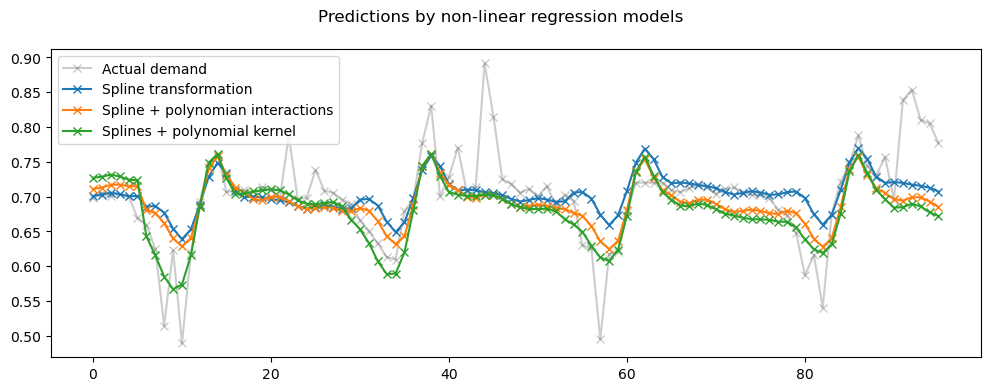

In [130]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline transformation",
)
ax.plot(
    cyclic_spline_interactions_predictions[last_hours],
    "x-",
    label="Spline + polynomian interactions",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()